# Lesson 4: Observe Agent Performance

In this lesson, you'll add tracing and evaluation to the data agent so you can observe and measure its performance.

In [1]:
import os
from dotenv import load_dotenv
import warnings

load_dotenv(override=True)
warnings.filterwarnings("ignore")

os.environ["TRULENS_OTEL_TRACING"] = "1"

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access <code>requirements.txt</code>, <code>.env.template</code>, <code>prompts.py</code>, and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>

## 4.1 RAG Triad Evaluations

Because data agents at their core are performing research and generation tasks, you can apply the RAG Triad to assess the data agent's goal completion.

Each step of a data agent's execution seeks to accomplish tasks which you can evaluate via the RAG triad:
- research can be evaluated using context relevance
- information synthesis can be evaluated with groundedness to assess response accuracy
- end-to-end relevance can be evaluated via answer relevance.

These metrics are evaluated with an LLM judge.

In [2]:
from trulens.providers.openai import OpenAI

# Use GPT-4o for RAG Triad Evaluations
provider = OpenAI(model_engine="gpt-4o")

**Groundedness Feedback Function**

The [groundedness feedback function](https://www.trulens.org/reference/trulens/feedback/?h=groundedness_measure_with_cot_reasons#trulens.feedback.LLMProvider.groundedness_measure_with_cot_reasons) expects two inputs:

- `source`: list of all contexts retrieved (output of the retrieval step)
- `statement`: the statement to check for groundedness, in this case `on_output()` which represents the final answer of the agent.

In [3]:
import numpy as np
from trulens.core import Feedback
from trulens.core.feedback.selector import Selector
from trulens.otel.semconv.trace import SpanAttributes

# Define a groundedness feedback function
f_groundedness = (
    Feedback(
        provider.groundedness_measure_with_cot_reasons, 
        name="Groundedness"
    )
    .on({
            "source": Selector(
                span_type=SpanAttributes.SpanType.RETRIEVAL,
                span_attribute=SpanAttributes.RETRIEVAL.RETRIEVED_CONTEXTS,
                collect_list=True
            )
        }
    )
    .on_output()
)

**Answer Relevance Feedback Function**

The [relevance feedback function](https://www.trulens.org/reference/trulens/feedback/?h=relevance_with_cot_reasons#trulens.feedback.LLMProvider.relevance) expects two inputs:
- `prompt` or user's query (`on_input()`)
- `response` or final answer of the agent (`on_output()`)

In [4]:
# Question/answer relevance between overall question and answer.
f_answer_relevance = (
    Feedback(provider.relevance_with_cot_reasons, name="Answer Relevance")
    .on_input()
    .on_output()
)

**Context Relevance Feedback Function**

The [relevance feedback function](https://www.trulens.org/reference/trulens/feedback/?query=context_relevance_with_cot_reasons#trulens.feedback.LLMProvider.context_relevance) expects two inputs:
- `question`: agent's sub-query
- `context`: context collected at the retrieval step

In [5]:
# Context relevance between question and each context chunk.
f_context_relevance = (
    Feedback(provider.context_relevance_with_cot_reasons, 
             ame="Context Relevance")
    .on({
            "question": Selector(
                span_type=SpanAttributes.SpanType.RETRIEVAL,
                span_attribute=SpanAttributes.RETRIEVAL.QUERY_TEXT,
            )
        }
    )
    .on({
            "context": Selector(
                span_type=SpanAttributes.SpanType.RETRIEVAL,
                span_attribute=SpanAttributes.RETRIEVAL.RETRIEVED_CONTEXTS,
                collect_list=False
            )
        }
    )
    .aggregate(np.mean)
)

## 4.2 Create TruLens session for logging

The database will store OpenTelemetry traces and evaluations (also in opentelemetry format) as events.

In [6]:
from trulens.core.session import TruSession
from trulens.core.database.connector.default import DefaultDBConnector

# Initialize connector with SQLite database one folder back
connector = DefaultDBConnector(database_url="sqlite:///default.sqlite")

# Create TruSession with the custom connector
session = TruSession(connector=connector)
session.reset_database()

🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


## 4.3 Add custom instrumentation to methods that produce intermediate context

In [7]:
from helper import cortex_agent, State
from trulens.core.otel.instrument import instrument
from langchain.schema import HumanMessage
from langgraph.graph import END
from langgraph.types import Command
from typing import Literal

In [8]:
@instrument(
    span_type=SpanAttributes.SpanType.RETRIEVAL,
    attributes=lambda ret, exception, *args, **kwargs: {
        SpanAttributes.RETRIEVAL.QUERY_TEXT: args[0].get("agent_query") if args[0].get("agent_query") else None,
        SpanAttributes.RETRIEVAL.RETRIEVED_CONTEXTS: [
            ret.update["messages"][-1].content
        ] if hasattr(ret, "update") else "No tool call",
    },
)
def cortex_agents_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    query = state.get("agent_query", state.get("user_query", ""))
    # Call the tool with the string query
    agent_response = cortex_agent.invoke({"messages":query})
    # Compose a message content string with all results new HumanMessage with the result
    new_message = HumanMessage(content=agent_response['messages'][-1].content, name="cortex_researcher")
    # Append to the message history
    goto = "executor"
    return Command(
        update={"messages": [new_message]},
        goto=goto,
    )

In [9]:
from helper import web_search_agent

@instrument(
    span_type=SpanAttributes.SpanType.RETRIEVAL,
    attributes=lambda ret, exception, *args, **kwargs: {
        SpanAttributes.RETRIEVAL.QUERY_TEXT: args[0].get("agent_query") if args[0].get("agent_query") else None,
        SpanAttributes.RETRIEVAL.RETRIEVED_CONTEXTS: [
            ret.update["messages"][-1].content
        ] if hasattr(ret, "update") else "No tool call",
    },
)
def web_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    agent_query = state.get("agent_query")
    result = web_search_agent.invoke({"messages":agent_query})
    goto = "executor"
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="web_researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## 4.4 Build the graph with added instrumentation

In [10]:
from langgraph.graph import START, StateGraph
from helper import State, planner_node, executor_node, cortex_agents_research_node, web_research_node, chart_node, chart_summary_node, synthesizer_node

workflow = StateGraph(State)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("web_researcher", web_research_node)
workflow.add_node("cortex_researcher", cortex_agents_research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("chart_summarizer", chart_summary_node)
workflow.add_node("synthesizer", synthesizer_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

## 4.5 Register the agent with TruLens

In [11]:
from trulens.apps.langgraph import TruGraph

tru_recorder = TruGraph(
    graph,
    app_name="Sales Data Agent",
    app_version="L4: Base",
    feedbacks=[
        f_answer_relevance,
        f_context_relevance,
        f_groundedness,
    ],
)

instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream


## 4.6 Record agent usage

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
<p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results may differ from those shown in the video.

**It's expected for the agent to not answer perfectly**:

- If the first query does not chart any results, or plots a chart showing companies A, B and C, or mentions that it doesn't have access to the required data, that's okay. It might be because the Cortex agent decided to choose the Cortex Search tool (access to meeting notes only) instead of the Cortex Analyst tool (access to client deals data). You do not need to re-run the queries.
  
- The same applies to the second and third queries. If the agent does not return a perfect answer, that's okay. You do not need to re-run it.
</div>

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following two queries might take <b>2-5 minutes</b> to output the results.</p>

Query: What are our top 3 client deals? Chart the deal value for each.


WARNI [langchain_experimental.utilities.python] Python REPL can execute arbitrary code. Use with caution.


Chart summarizer answer: FINAL ANSWER

The top three client deals by value show FastTrack Ltd with the highest deal at $180,000, followed by SecureBank Ltd at $150,000, and HealthTech Solutions at $120,000. The deals are represented side-by-side for easy comparison of their respective values.
--------------------------------


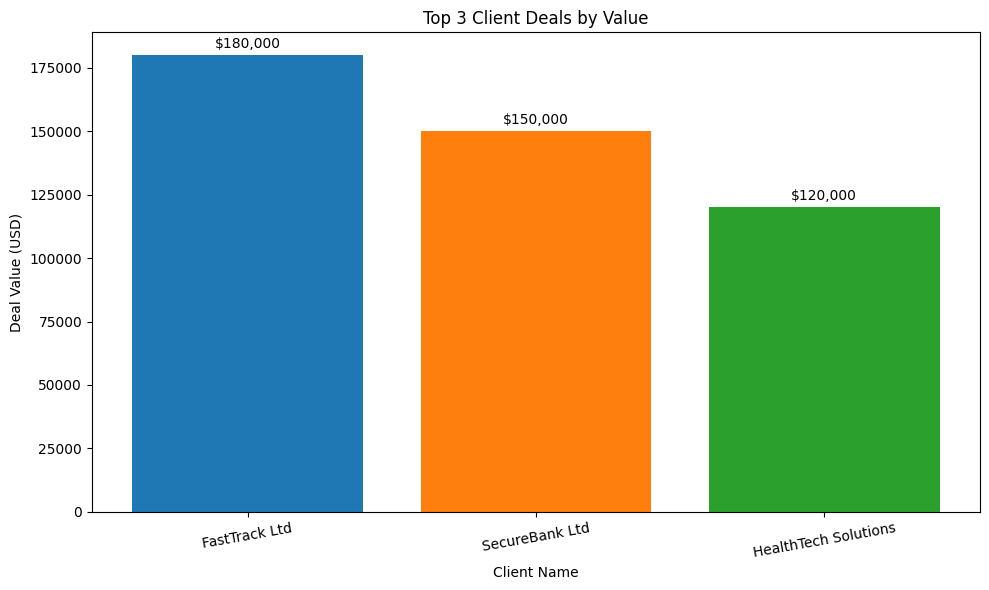

In [12]:
from langchain.schema import HumanMessage

with tru_recorder as recording:
    query = "What are our top 3 client deals? Chart the deal value for each."
    print(f"Query: {query}")
    state = {
                "messages": [HumanMessage(content=query)],
                "user_query": query,
                "enabled_agents": ["cortex_researcher", "web_researcher", 
                                   "chart_generator", "chart_summarizer", 
                                   "synthesizer"],
            }
    graph.invoke(state)

    print("--------------------------------")

In [13]:
with tru_recorder as recording:
    query = "Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes."
    print(f"Query: {query}")
    state = {
                "messages": [HumanMessage(content=query)],
                "user_query": query,
                "enabled_agents": ["cortex_researcher", "web_researcher", 
                                   "chart_generator", "chart_summarizer", 
                                   "synthesizer"],
            }
    graph.invoke(state)

    print("--------------------------------")

Query: Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes.
Synthesizer answer: - **Pending Deals and Industries**:
  1. **TechCorp Inc**: Technology
  2. **LegalEase Corp**: Legal
  3. **DataDriven Co**: Analytics
  4. **SecureBank Ltd**: Banking
  5. **SmallBiz Solutions**: Small Business (Deal Value: $30K)

- **Regulatory Changes and Value Propositions**:
  1. **TechCorp Inc**: In light of recent data privacy regulations in technology, emphasize enhanced compliance features and data security within the enterprise solutions to facilitate smoother compliance audits.
  2. **LegalEase Corp**: With ongoing changes in legal practice standards, highlight robust document management and e-discovery capabilities to ensure adherence to the latest legal compliances and efficiency in legal processes.
  3. **DataDriven Co**: New analytics regulation

In [ ]:
with tru_recorder as recording:
    query = "Identify our largest client deal, then find important topics in the meeting notes with that company, and find a news article related to the important topics discussed."
    print(f"Query: {query}")
    state = {
                "messages": [HumanMessage(content=query)],
                "user_query": query,
                "enabled_agents": ["cortex_researcher", "web_researcher", 
                                   "chart_generator", "chart_summarizer", 
                                   "synthesizer"],
            }
    graph.invoke(state)

    print("--------------------------------")

Query: Identify our largest client deal, then find important topics in the meeting notes with that company, and find a news article related to the important topics discussed.


## 4.7 Launch the TruLens dashboard

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> If the evaluation metrics do not directly show in the dashboard, you can wait a few minutes so that the database is populated with all the values for the evaluation metrics.</p>

**Note:** Make sure to click on the second link (not the localhost) to open the TruLens dashboard.

In [ ]:
from trulens.dashboard import run_dashboard
import os
str_port = 8001
_ = run_dashboard(port=str_port)
print(os.environ['DLAI_LOCAL_URL'].format(port=str_port))